## Importing libraries

In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
import os
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from joblib import dump

## Dataset Exploration


#### Loading dataset

In [2]:
dataset_path = r'plantvillage-dataset/color'
tomato_directories = [os.path.join(dataset_path, folder) for folder in os.listdir(dataset_path) if 'Tomato' in folder]

#### Example image of each class

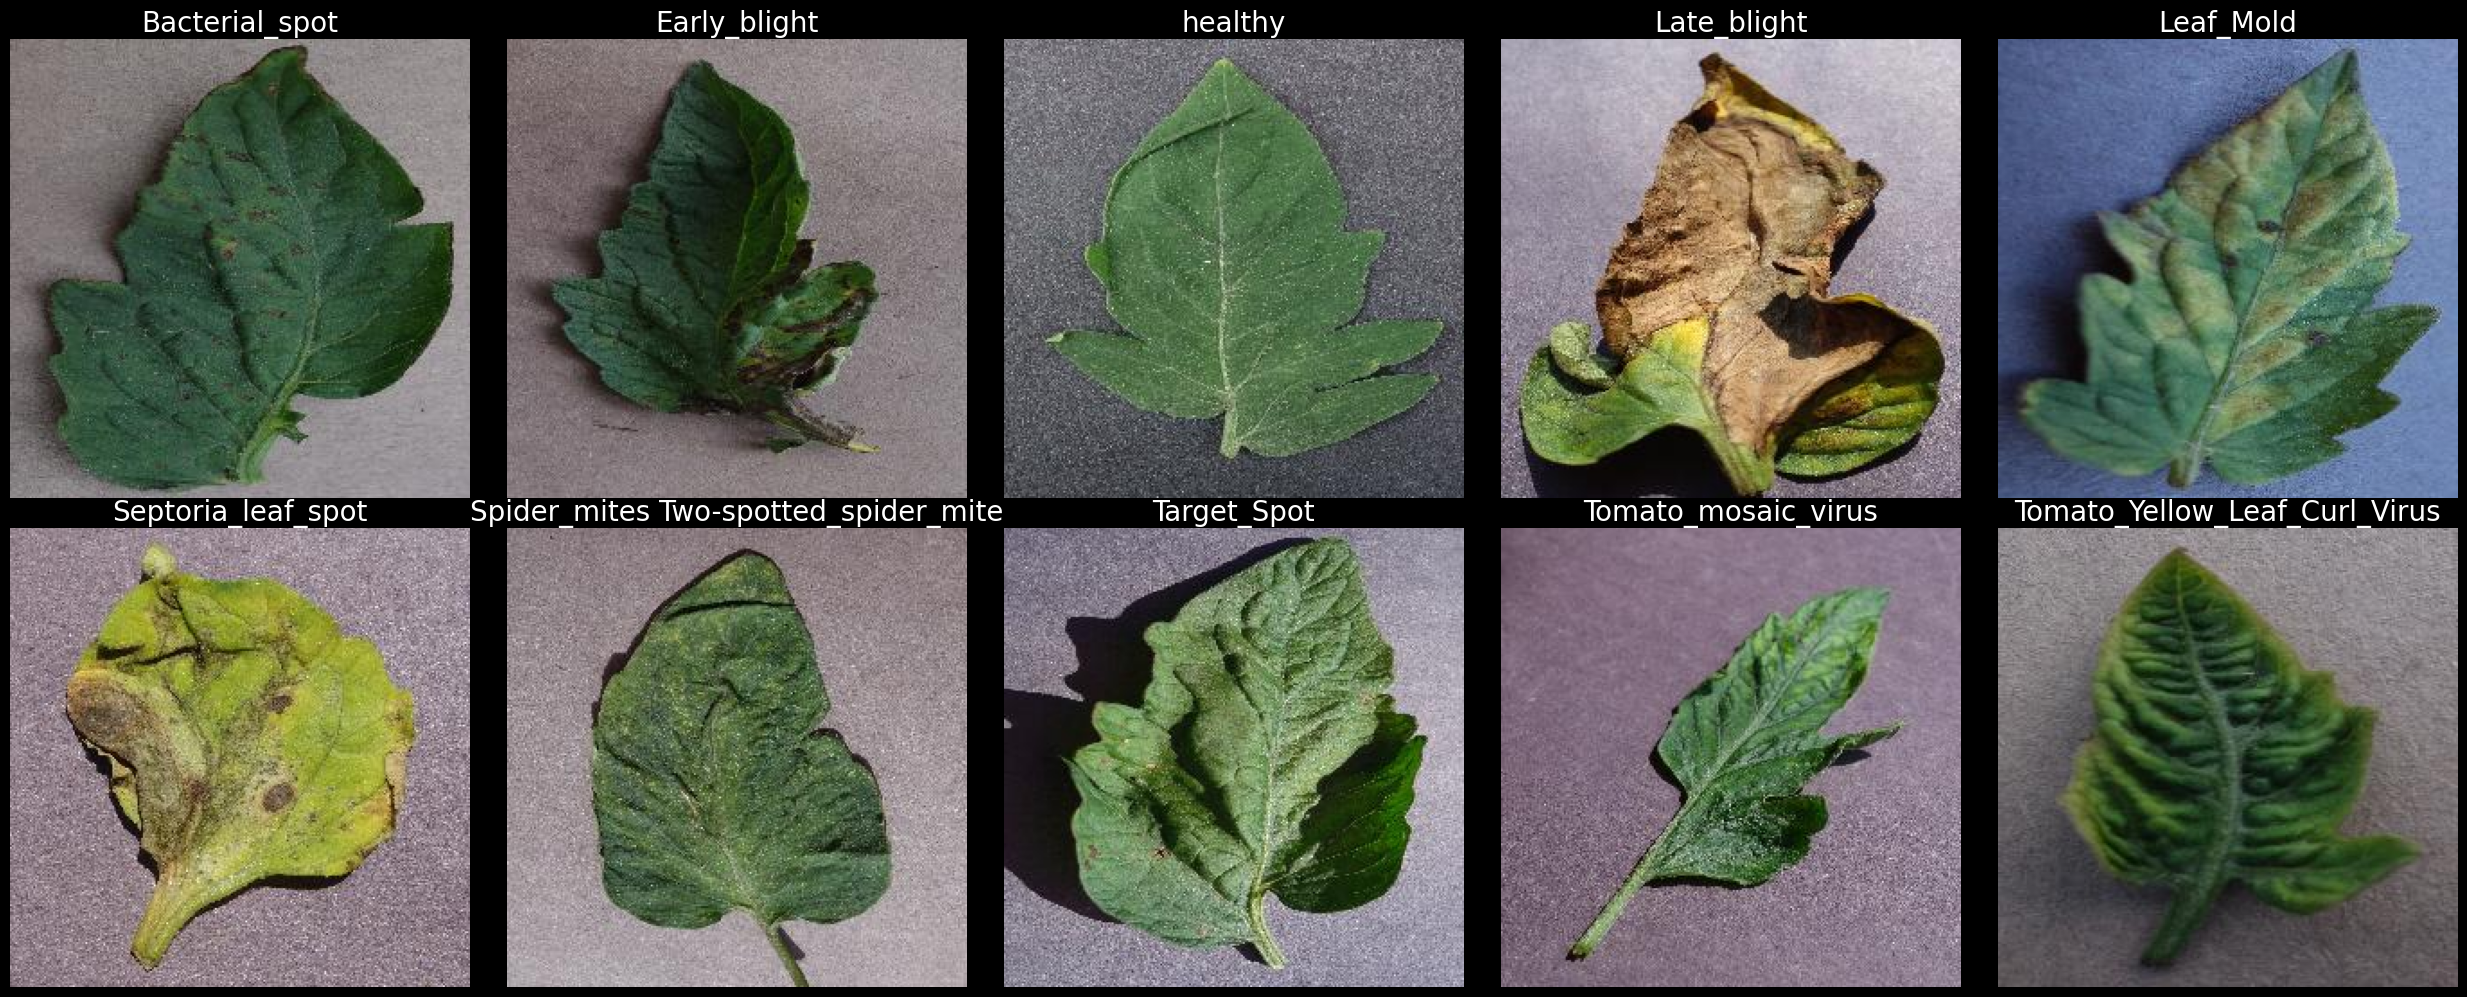

In [3]:
fig, axis = plt.subplots(nrows = 2, ncols = 5, figsize = (25, 10))
axis = axis.flatten()
for tomato_dir, ax in zip(tomato_directories, axis):
    image_path = os.path.join(tomato_dir, random.choice(os.listdir(tomato_dir)))
    image = plt.imread(image_path)
    ax.axis('off')
    ax.set_title(os.path.basename(tomato_dir)[9:], fontsize = 20)
    ax.imshow(image)
plt.tight_layout()
plt.show()

Bacterial_spot: 2127
Early_blight: 1000
healthy: 1591
Late_blight: 1909
Leaf_Mold: 952
Septoria_leaf_spot: 1771
Spider_mites Two-spotted_spider_mite: 1676
Target_Spot: 1404
Tomato_mosaic_virus: 373
Tomato_Yellow_Leaf_Curl_Virus: 5357


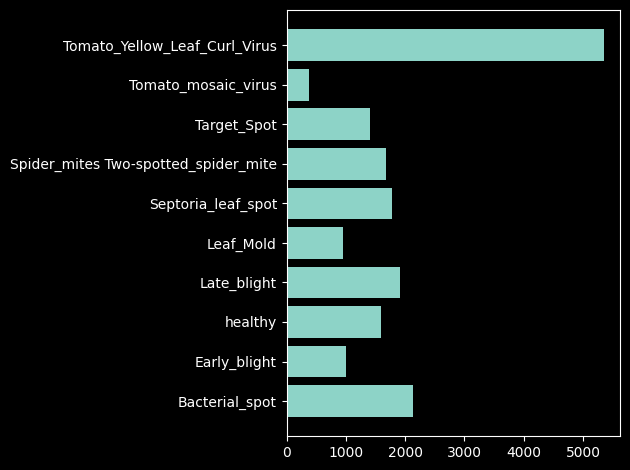

In [4]:
tomato_diseases = [os.path.basename(tomato_dir)[9:] for tomato_dir in tomato_directories]
number_of_images = [len(os.listdir(tomato_dir)) for tomato_dir in tomato_directories]
for tomato_disease, num in zip(tomato_diseases, number_of_images): print(str(tomato_disease)+": "+str(num))
plt.barh(tomato_diseases, number_of_images)
plt.tight_layout()
plt.show()

#### Image preprocessing

In [5]:
# Limiting the number of images to 1000 for every class of disease
images = []
labels = []

for i, tomato_dir in enumerate(tomato_directories):
    print("Started: "+str(os.path.basename(tomato_dir)))
    for file in os.listdir(tomato_dir)[:370]:
        image_path = os.path.join(tomato_dir, file)
        image = plt.imread(image_path)
        images.append(image)
        labels.append(os.path.basename(tomato_dir)[9:])
    print("Finished. {} classes left.".format(len(tomato_directories)-1-i))

images = np.array(images)
labels = np.array(labels)

Started: Tomato___Bacterial_spot
Finished. 9 classes left.
Started: Tomato___Early_blight
Finished. 8 classes left.
Started: Tomato___healthy
Finished. 7 classes left.
Started: Tomato___Late_blight
Finished. 6 classes left.
Started: Tomato___Leaf_Mold
Finished. 5 classes left.
Started: Tomato___Septoria_leaf_spot
Finished. 4 classes left.
Started: Tomato___Spider_mites Two-spotted_spider_mite
Finished. 3 classes left.
Started: Tomato___Target_Spot
Finished. 2 classes left.
Started: Tomato___Tomato_mosaic_virus
Finished. 1 classes left.
Started: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Finished. 0 classes left.


In [6]:
images = images/255.0
labels

array(['Bacterial_spot', 'Bacterial_spot', 'Bacterial_spot', ...,
       'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_Yellow_Leaf_Curl_Virus',
       'Tomato_Yellow_Leaf_Curl_Virus'], dtype='<U36')

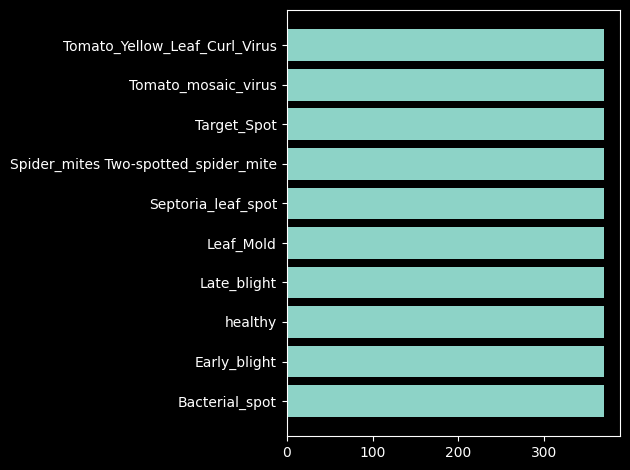

In [7]:
# Class distribution
c = Counter(labels)
l = list(c.keys())
n = list(c.values())
plt.barh(l, n)
plt.tight_layout()
plt.show()

#### Train Test Split

In [8]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = 42)

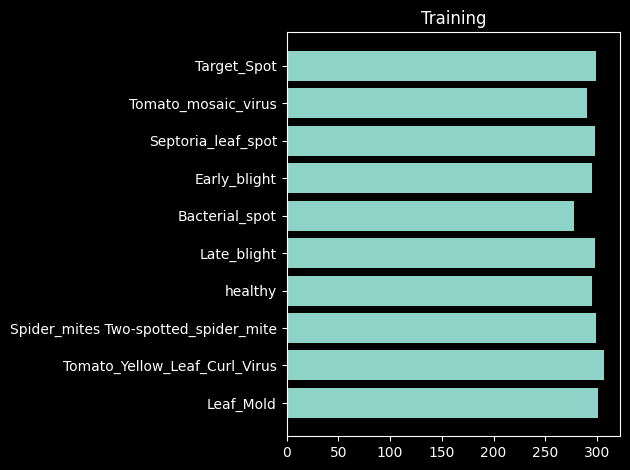

In [9]:
# Training class distribution
c = Counter(y_train)
l = list(c.keys())
n = list(c.values())
plt.barh(l, n)
plt.title('Training')
plt.tight_layout()
plt.show()

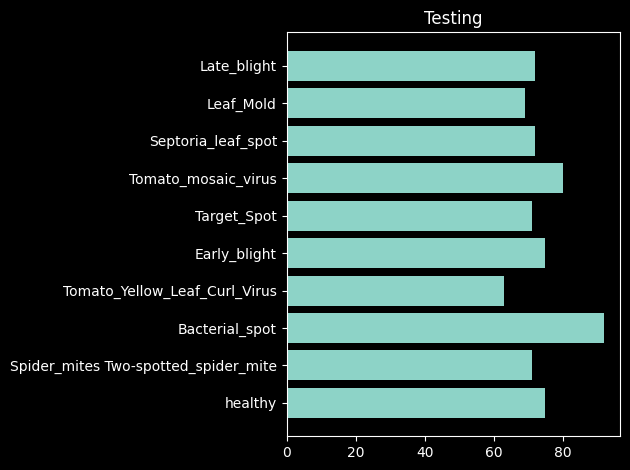

In [10]:
# Training class distribution
c = Counter(y_test)
l = list(c.keys())
n = list(c.values())
plt.barh(l, n)
plt.title('Testing')
plt.tight_layout()
plt.show()

#### One Hot Encoding of Training Labels

In [11]:
reshaped_labels = y_train.reshape(-1, 1)
encoder = OneHotEncoder(sparse_output = False)
encoded_labels = encoder.fit_transform(reshaped_labels)

In [12]:
encoder.categories_

[array(['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold',
        'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite',
        'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus',
        'Tomato_mosaic_virus', 'healthy'], dtype='<U36')]

## Model Architecture:

In [58]:
def cnn_model(input_shape, number_of_classes):
    input_image = Input(shape=(input_shape), name='input_layer')
    
    #Block 1: Input Layer
    x = Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu', name = 'conv_1_1')(input_image)
    x = MaxPooling2D(pool_size = (2,2), strides = (2,2))(x)
    x = Dropout(0.25, name = 'dropout_layer_1')(x)
    
    #Block 2:
    x = Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu', name = 'conv_2_1')(x)
    x = MaxPooling2D(pool_size = (2,2), strides = (2,2))(x)
    x = Dropout(0.25, name = 'dropout_layer_2')(x)
    
    #Block 3:
    x = Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu', name = 'conv_3_1')(x)
    x = MaxPooling2D(pool_size = (2,2), strides = (2,2))(x)
    x = Dropout(0.25, name = 'dropout_layer_3')(x)
    
    #Flatten:
    x = Flatten()(x)
    
    #Dense Layer:
    x = Dense(128, activation = 'relu', name = 'dense_1')(x)
    x = Dense(128, activation = 'relu', name = 'dense_2')(x)
    x = Dense(64, activation = 'relu', name = 'dense_3')(x)
    x = Dense(number_of_classes, activation = 'softmax', name = 'output_dense_layer')(x)
    
    model = Model(inputs = input_image, outputs = x)
    
    return model

In [59]:
tomato_classifier = cnn_model((256, 256, 3), 10)
tomato_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
tomato_classifier.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_1 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_1 (Dropout)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_2 (Dropout)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_3 (Dropout)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,896,010 (64.45 MB)

 Trainable params: 16,896,010 (64.45 MB)

 Non-trainable params: 0 (0.00 B)

#### Training Dataset

In [60]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)
history = tomato_classifier.fit(x_train, encoded_labels, epochs = 20, batch_size = 32, validation_split=0.2, callbacks = [early_stopping])

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 64s 783ms/step - accuracy: 0.0982 - loss: 2.7629 - val_accuracy: 0.2973 - val_loss: 2.0446
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 55s 742ms/step - accuracy: 0.2947 - loss: 1.9204 - val_accuracy: 0.5068 - val_loss: 1.5257
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 73s 987ms/step - accuracy: 0.5454 - loss: 1.2998 - val_accuracy: 0.5422 - val_loss: 1.2233
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.6329 - loss: 1.0230 - val_accuracy: 0.6841 - val_loss: 0.9330
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.7354 - loss: 0.7665 - val_accuracy: 0.7061 - val_loss: 0.8735
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.7873 - loss: 0.6568 - val_accuracy: 0.7314 - val_loss: 0.8189
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 57s 775ms/step - accuracy: 0.8354 - loss: 0.5242 - val_accuracy: 0.7297 - val_loss: 0.7735
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8561 - loss: 0.4087 - val_accuracy: 0.777

In [61]:
pred = tomato_classifier.predict(x_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step


In [62]:
predictions = []
for p in pred:
    predictions.append(encoder.categories_[0][np.argmax(p)])

In [63]:
predictions

['healthy',
 'Tomato_mosaic_virus',
 'Bacterial_spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'healthy',
 'Bacterial_spot',
 'Early_blight',
 'healthy',
 'Target_Spot',
 'Tomato_mosaic_virus',
 'Bacterial_spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Bacterial_spot',
 'Bacterial_spot',
 'Target_Spot',
 'Bacterial_spot',
 'Target_Spot',
 'healthy',
 'Spider_mites Two-spotted_spider_mite',
 'Bacterial_spot',
 'Tomato_mosaic_virus',
 'Target_Spot',
 'Early_blight',
 'Leaf_Mold',
 'Target_Spot',
 'Late_blight',
 'Spider_mites Two-spotted_spider_mite',
 'Late_blight',
 'Target_Spot',
 'Early_blight',
 'Target_Spot',
 'healthy',
 'Late_blight',
 'Early_blight',
 'Target_Spot',
 'Bacterial_spot',
 'Early_blight',
 'Target_Spot',
 'Tomato_mosaic_virus',
 'Septoria_leaf_spot',
 'healthy',
 'Bacterial_spot',
 'Septoria_leaf_spot',
 'Early_blight',
 'Septoria_leaf_spot',
 'Bacterial_spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Early_blight',
 'healthy',
 'Septoria_leaf_spot',
 'Tomato_mosaic_virus',
 'Spi

In [64]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
accuracy

0.7837837837837838

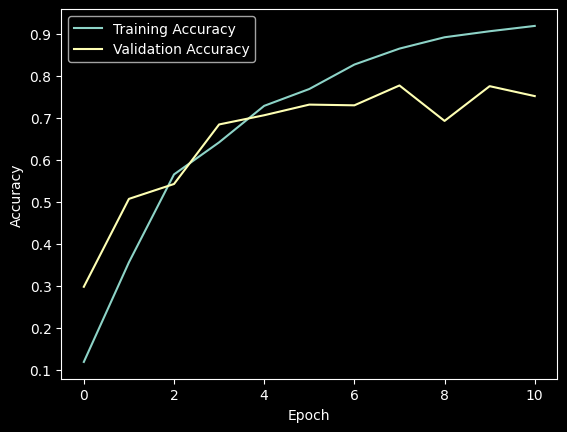

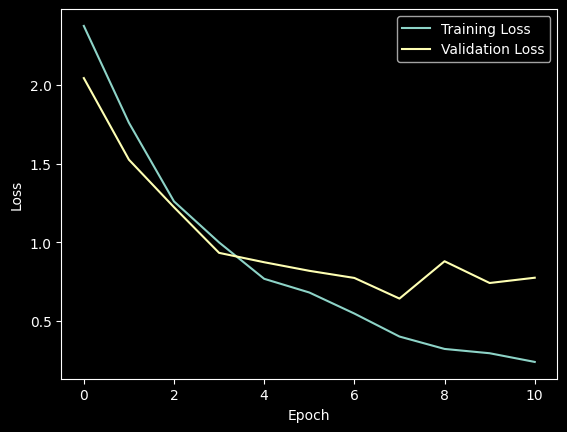

In [65]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [66]:
tomato_classifier.save("model_weights/my_model_84.keras", include_optimizer=True)

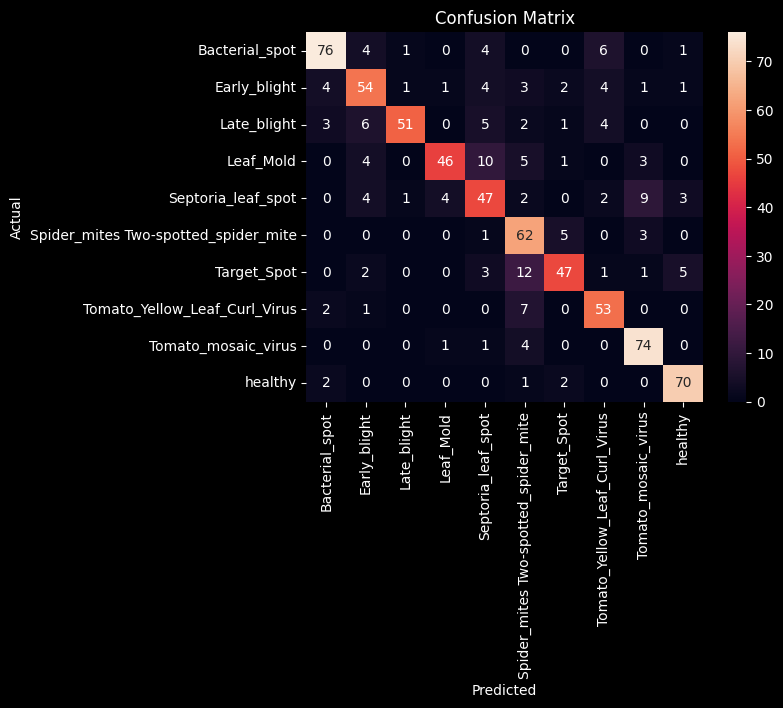

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
cm = confusion_matrix(y_test, predictions)
sn.heatmap(cm, annot=True, xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()